# Autograd

Sorix's **`autograd`** engine automatically computes the derivatives of functions defined using Tensors, enabling automatic differentiation. This capability eliminates the need for manual derivative implementation, allowing developers to focus on defining the computational logic.

Every operation involving a **`tensor`** contributes to building a **Computational Graph**  that records the history of calculations. The crucial **`.backward()`** method then traverses this graph in reverse, applying the **chain rule** to determine the gradients of the output with respect to the input Tensors.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/develop/docs/learn/autograd.ipynb)


## Example: Finding the Minimum of $f(x, y) = x^2 + y^2$

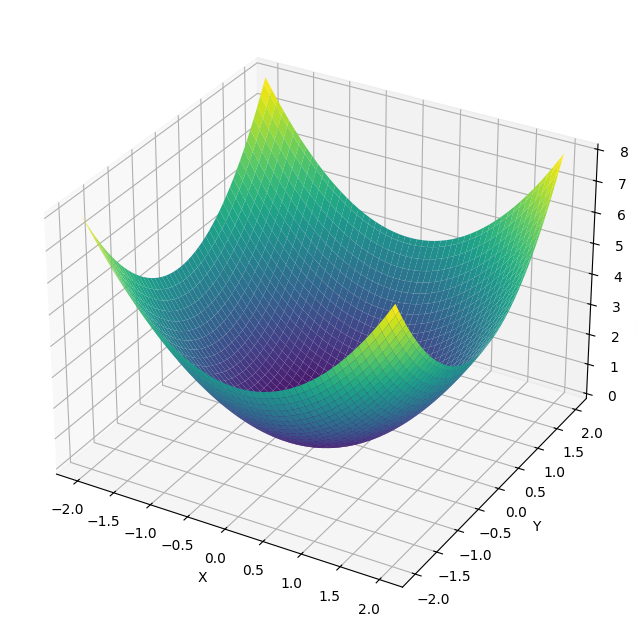

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$Z=f(X,Y) = X^2 + Y^2$')
plt.show()

### Computation of Partial Derivatives (Gradient)

To determine maxima and minima, we must locate the critical points of the function. This requires computing the partial derivatives with respect to each variable. These derivatives together form the **gradient vector** ($\nabla f$).

$$
\frac{\partial f}{\partial x} = 2x
$$

$$
\frac{\partial f}{\partial y} = 2y
$$

The gradient of the function is:
$$
\nabla f(x, y) = \left\langle \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right\rangle = \langle 2x, 2y \rangle
$$

This is where Sorix comes into play, helping us compute these partial derivatives automatically using a computational graph. We will explore this in more detail later.


In [2]:
from sorix import tensor


x = tensor([3.0], requires_grad=True)
y = tensor([4.0], requires_grad=True)

f_output = x**2 + y**2

f_output.backward()

print(f"df/dx: {x.grad}")
print(f"df/dy: {y.grad}")

df/dx: [6.]
df/dy: [8.]


### Explanation of the Result

When `f_output.backward()` is called, Sorix evaluates the recorded computational graph. The resulting partial derivatives are stored in the **`.grad`** attribute of the respective input Tensors, $x$ and $y$.

  * **$\frac{\partial f}{\partial x}$** is correctly computed as **6.0**.
  * **$\frac{\partial f}{\partial y}$** is correctly computed as **8.0**.

These gradient values indicate the direction and magnitude of the steepest ascent from the current point $(3.0, 4.0)$ on the surface of $f(x, y)$. In an optimization routine, these gradients would be used to move the parameters $x$ and $y$ towards the minimum (which is at $(0, 0)$).

### 2. Algebraic Search for the Minimum (Critical Points)

A critical point occurs where the gradient is zero ($\nabla f = \mathbf{0}$).

$$
\frac{\partial f}{\partial x} = 2x = 0 \implies x = 0
$$

$$
\frac{\partial f}{\partial y} = 2y = 0 \implies y = 0
$$

The only critical point is $(0, 0)$. Evaluating the function at this point gives the minimum value:
$$
f(0, 0) = 0^2 + 0^2 = 0
$$
This direct solution is possible because the function is convex and simple.

## Iterative Optimization Methods

In **machine learning** and complex models, the cost (or loss) function $ J(\mathbf{w}) $ is a high-dimensional surface, and its gradient (the partial derivatives with respect to all weights $\mathbf{w} $ is far too complex to set equal to zero algebraically.

For this reason, instead of solving the problem directly, we rely on **iterative methods** that **gradually converge** toward the minimum. The most fundamental of these is the **Gradient Descent Method**.

### 3. The Gradient Descent Method

Gradient Descent is a **first-order** optimization algorithm used to find the local minimum of a function. It is based on the principle that the direction of **maximum increase** of a function at a point is the direction of the **gradient vector** ($\nabla f$).

Therefore, the direction of **maximum decrease** is the **opposite** of the gradient ($-\nabla f$).

#### Algorithm Steps

1. **Initialization:** Choose a random initial point $\mathbf{w}_0 $ on the cost function surface $J(\mathbf{w}) $.

2. **Gradient Calculation:** At the current point $\mathbf{w}_t $, compute the gradient $\nabla J(\mathbf{w}_t)$.

3. **Parameter Update:** Move the parameters in the direction opposite to the gradient, using the update rule:

   $$
   \mathbf{w}_{t+1} = \mathbf{w}_t - \eta \cdot \nabla J(\mathbf{w}_t)
   $$

   Where:

   * $ \mathbf{w}_{t+1} $ is the new set of parameters (weights).
   * $ \mathbf{w}_t $ is the current set of parameters.
   * $ \nabla J(\mathbf{w}_t) $ is the gradient (vector of partial derivatives) of the cost function at $ \mathbf{w}_t $.
   * **$ \eta $** is the **learning rate**. This is a crucial hyperparameter controlling the size of the “step” toward the minimum.

   * If $ \eta $ is too large, the algorithm may **overshoot the minimum** (divergence).
   * If $ \eta $ is too small, convergence becomes very slow.

4. **Convergence:** This process is repeated **iteratively** (epochs) until the update steps become negligible (i.e., the gradient approaches zero) or a maximum number of iterations is reached, indicating that a local minimum has been found.

## Finding the Minimum of $ f(x, y) = x^2 + y^2 $ with Gradient Descent

$$
(x, y)_{t+1} = (x, y)_t - \eta \cdot \nabla f(x, y), \quad t=0,1,2,\dots,20
$$

With:

* Initial point $ (x, y)_0 = (3, 4) $
* Learning rate $ \eta = 0.1 $


In [8]:
from sorix import tensor, no_grad

# Gradient descent hyperparameters
lr = 0.1
iters = 50

# Initial variables
x = tensor([3.0], requires_grad=True)
y = tensor([4.0], requires_grad=True)

# Initial computation
f = x**2 + y**2
f.backward()

dx0 = x.grad.item()
dy0 = y.grad.item()

print("Iter |     x    |     y    |  df/dx   |  df/dy   |   f(x,y)")
print("--------------------------------------------------------------------")
print(f"{0:4d} | {x.item():8.4f} | {y.item():8.4f} | {dx0:8.4f} | {dy0:8.4f} | {f.item():9.4f}")

# Cleanup before loop
x.grad = 0
y.grad = 0

for i in range(1, iters + 1):

    # Forward compute f(x,y)
    f = x**2 + y**2

    # Backward compute df/dx and df/dy
    f.backward()
    
    dx = x.grad
    dy = y.grad

    # Update x and y values
    x -= lr * x.grad
    y -= lr * y.grad

    # Periodic print
    if i % 5 == 0:
        print(f"{i:4d} | {x.item():8.4f} | {y.item():8.4f} | {dx.item():8.4f} | {dy.item():8.4f} | {f.item():9.4f}")

    # Reset
    x.grad = 0
    y.grad = 0

# Final result
f_final = x**2 + y**2
print("\nFinal result:")
print(f"x = {x.item():.6f}")
print(f"y = {y.item():.6f}")
print(f"f(x,y) = {f_final.item():.6f}")


Iter |     x    |     y    |  df/dx   |  df/dy   |   f(x,y)
--------------------------------------------------------------------
   0 |   3.0000 |   4.0000 |   6.0000 |   8.0000 |   25.0000
   5 |   0.9830 |   1.3107 |   2.4576 |   3.2768 |    4.1943
  10 |   0.3221 |   0.4295 |   0.8053 |   1.0737 |    0.4504
  15 |   0.1056 |   0.1407 |   0.2639 |   0.3518 |    0.0484
  20 |   0.0346 |   0.0461 |   0.0865 |   0.1153 |    0.0052
  25 |   0.0113 |   0.0151 |   0.0283 |   0.0378 |    0.0006
  30 |   0.0037 |   0.0050 |   0.0093 |   0.0124 |    0.0001
  35 |   0.0012 |   0.0016 |   0.0030 |   0.0041 |    0.0000
  40 |   0.0004 |   0.0005 |   0.0010 |   0.0013 |    0.0000
  45 |   0.0001 |   0.0002 |   0.0003 |   0.0004 |    0.0000
  50 |   0.0000 |   0.0001 |   0.0001 |   0.0001 |    0.0000

Final result:
x = 0.000043
y = 0.000057
f(x,y) = 0.000000


## graphically

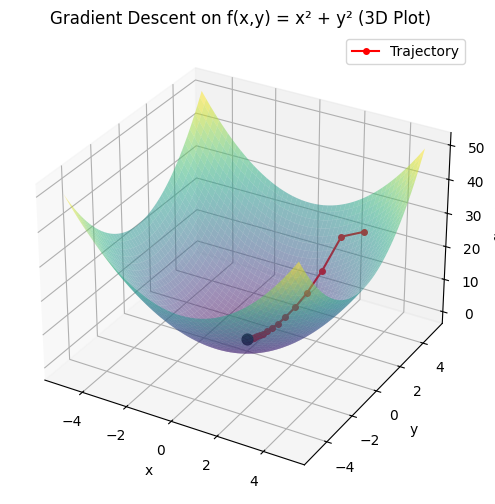

In [10]:
from sorix import tensor
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Gradient descent hyperparameters
lr = 0.1
iters = 50

# Initial variables
x = tensor([3.0], requires_grad=True)
y = tensor([4.0], requires_grad=True)
f = x**2 + y**2

# History for plotting
xs = [x.item()]
ys = [y.item()]
fs = [f.item()]

# Initial evaluation
f.backward()

# Initial reset
x.grad = 0
y.grad = 0

for i in range(1, iters + 1):

    # Forward
    f = x**2 + y**2

    # Backward
    f.backward()

    # Update
    x -= lr * x.grad
    y -= lr * y.grad

    # Save trajectory
    xs.append(x.item())
    ys.append(y.item())
    fs.append(f.item())

    # Reset gradients
    x.grad = 0
    y.grad = 0

# -----------------------------
# 3D plot of the surface + trajectory
# -----------------------------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Surface f(x,y) = x^2 + y^2
X = np.linspace(-5, 5, 200)
Y = np.linspace(-5, 5, 200)
XX, YY = np.meshgrid(X, Y)
ZZ = XX**2 + YY**2

ax.plot_surface(XX, YY, ZZ, alpha=0.5, cmap='viridis')

# Gradient descent trajectory
ax.plot(xs, ys, fs, marker='o', color='red', markersize=4, label="Trajectory")

# Final point
ax.scatter(xs[-1], ys[-1], fs[-1], color='black', s=60)

ax.set_title("Gradient Descent on f(x,y) = x² + y² (3D Plot)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")
ax.legend()

plt.show()
